In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
import time
import sklearn

2023-01-19 16:20:09.059170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 16:20:09.411309: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-19 16:20:09.411329: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-19 16:20:10.443018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Importo i dati in pandas

In [2]:
df = pd.read_csv('WELFake_Dataset.csv')

In [3]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


# Preparazione dei dati
- riempimento dati mancanti con stringa vuota
- concatenzione di titolo e testo per ottere separati da spazio
- rimozione colonne inutilizzate (id, titolo, testo)
- suddivisione dataframe in set di training e test

In [5]:
df.fillna(value='', inplace=True)
df['full-article'] = df['title']+' '+df['text']
data=df.drop(['Unnamed: 0', 'title', 'text'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(data['full-article'], data['label'], test_size=0.20, random_state=42)

# Costruzione e addestamento modello di base

In [6]:
max_features=50
vectorize_layer=TextVectorization(max_tokens=max_features, output_mode='binary')
vectorize_layer.adapt(X_train)

model=tf.keras.Sequential()
model.add(tf.keras.Input(shape=(), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Dense(20, activation='relu', name='dense_1'))
model.add(tf.keras.layers.Dense(2, activation='softmax', name='dense_2'))

model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=tf.keras.metrics.SparseCategoricalAccuracy())

callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        min_delta=0.01,
        patience=3,
        restore_best_weights=True
    )
]

history=model.fit(
    x=X_train, 
    y=y_train,
    validation_split=0.2,
    epochs=10,
    callbacks=callbacks,
    batch_size=64
)

2023-01-19 16:20:14.381996: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-19 16:20:14.382056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marco-pc): /proc/driver/nvidia/version does not exist
2023-01-19 16:20:14.383785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
722/722 [==============================] - 7s 8ms/step - loss: 0.5015 - sparse_categorical_accuracy: 0.7637 - val_loss: 0.4558 - val_sparse_categorical_accuracy: 0.7948
Epoch 2/10
722/722 [==============================] - 5s 7ms/step - loss: 0.4411 - sparse_categorical_accuracy: 0.7984 - val_loss: 0.4379 - val_sparse_categorical_accuracy: 0.8012
Epoch 3/10
722/722 [==============================] - 5s 7ms/step - loss: 0.4248 - sparse_categorical_accuracy: 0.8055 - val_loss: 0.4251 - val_sparse_categorical_accuracy: 0.8088
Epoch 4/10
722/722 [==============================] - 5s 7ms/step - loss: 0.4132 - sparse_categorical_accuracy: 0.8098 - val_loss: 0.4152 - val_sparse_categorical_accuracy: 0.8086
Epoch 5/10
722/722 [==============================] - 5s 7ms/step - loss: 0.4075 - sparse_categorical_accuracy: 0.8126 - val_loss: 0.4159 - val_sparse_categorical_accuracy: 0.8060
Epoch 6/10
722/722 [==============================] - 5s 7ms/step - loss: 0.4033 - sparse_categorica

## Salvo il modello per non dover ripetere ogni volta l'addestramento

In [7]:
model.save('base_model.tf')
base_model = keras.models.load_model('base_model.tf')

INFO:tensorflow:Assets written to: base_model.tf/assets


INFO:tensorflow:Assets written to: base_model.tf/assets


In [8]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 50)               0         
 torization)                                                     
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 2)                 42        
                                                                 
Total params: 1,062
Trainable params: 1,062
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot: >

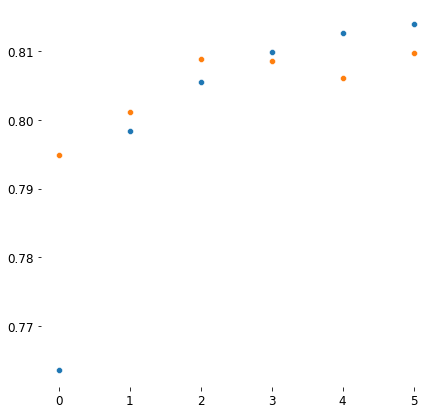

In [9]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize  = (7, 7))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
sns.scatterplot(x=history.epoch ,y=history.history['sparse_categorical_accuracy'])
sns.scatterplot(x=history.epoch ,y=history.history['val_sparse_categorical_accuracy'])

## Analisi prestazioni del modello di base sui dati di test

- classification_report
- matrice di confusione

In [10]:
pred=base_model.predict(X_test)
y_pred=np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

451/451 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      7089
           1       0.84      0.77      0.81      7338

    accuracy                           0.81     14427
   macro avg       0.81      0.81      0.81     14427
weighted avg       0.81      0.81      0.81     14427



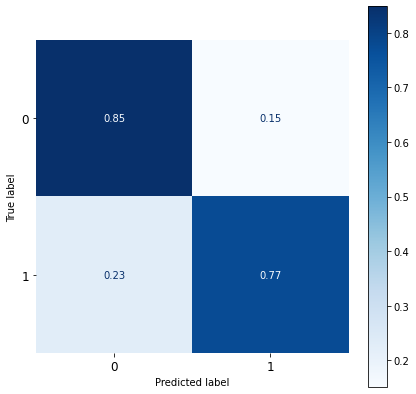

In [11]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize  = (7, 7))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Blues', ax=ax)
#plt.savefig("cf_matrixb.svg",bbox_inches='tight')

# Ottimizzazione degli iperparametri con Hyperband
## 1. vectorize_layer

Definisco un layer di vettorizzazione con un vocabolario di massimo 3000 elementi

## 2. build_model

Definisco una funzione che restituisce un modello sulla base degli iperparametri passati dal tuner

## 3. Callbacks

Imposto delle condizioni per l'early stopping

## 4. Tuner

Definisco un tuner basato sull'algoritmo Hyperband implementato in Keras_tuner

In [12]:
vectorize_layer=TextVectorization(max_tokens=3000, output_mode='binary')
vectorize_layer.adapt(X_train)

def build_model(hp):
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(1), dtype=tf.string))
    model.add(vectorize_layer)
    for i in range(hp.Int('dense_layers', 1, 3)):
        units=hp.Int(f'units_{i}', min_value=10, max_value=100, step=10)
        if hp.Boolean('dropout'):
            model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Dense(units=units, activation='relu', name=f'dense_{i}'))
    model.add(tf.keras.layers.Dense(2, activation='softmax', name='output'))
    
    
    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=keras.metrics.SparseCategoricalAccuracy()
   )
    
    return model

callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        min_delta=0.01,
        patience=3,
        restore_best_weights=True
    )
]
tuner = kt.Hyperband(build_model,
                     objective='val_sparse_categorical_accuracy',
                     max_epochs=15,
                     factor=3,
                     seed=42,
                     directory='log',
                     project_name='keras_tuning'
                     )

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project log/keras_tuning/oracle.json


INFO:tensorflow:Reloading Oracle from existing project log/keras_tuning/oracle.json


INFO:tensorflow:Reloading Tuner from log/keras_tuning/tuner0.json


INFO:tensorflow:Reloading Tuner from log/keras_tuning/tuner0.json


Search space summary
Default search space size: 5
dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': None}


## Esecuzione ottimizzazione

In [13]:
tuner.search(X_train, y_train, epochs=15, validation_split=0.2, callbacks=callbacks, batch_size=64)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [14]:
best_hps.values

{'dense_layers': 2,
 'units_0': 90,
 'dropout': False,
 'units_1': 20,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0013'}

## Addestramento modello finale utilizzando gli iperparametri selezionati

In [15]:
final_model = tuner.hypermodel.build(best_hps)
history = final_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=callbacks, batch_size=64)

Epoch 1/50
722/722 [==============================] - 8s 10ms/step - loss: 0.1213 - sparse_categorical_accuracy: 0.9577 - val_loss: 0.0759 - val_sparse_categorical_accuracy: 0.9743
Epoch 2/50
722/722 [==============================] - 7s 9ms/step - loss: 0.0439 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.0703 - val_sparse_categorical_accuracy: 0.9766
Epoch 3/50
722/722 [==============================] - 6s 9ms/step - loss: 0.0192 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.0761 - val_sparse_categorical_accuracy: 0.9755
Epoch 4/50
722/722 [==============================] - 6s 9ms/step - loss: 0.0088 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.1144 - val_sparse_categorical_accuracy: 0.9739


In [16]:
final_model.save('final_model.tf')
final_model = keras.models.load_model('final_model.tf')

INFO:tensorflow:Assets written to: final_model.tf/assets


INFO:tensorflow:Assets written to: final_model.tf/assets


In [17]:
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 3000)             0         
 ectorization)                                                   
                                                                 
 dense_0 (Dense)             (None, 90)                270090    
                                                                 
 dense_1 (Dense)             (None, 20)                1820      
                                                                 
 output (Dense)              (None, 2)                 42        
                                                                 
Total params: 271,952
Trainable params: 271,952
Non-trainable params: 0
_________________________________________________________________


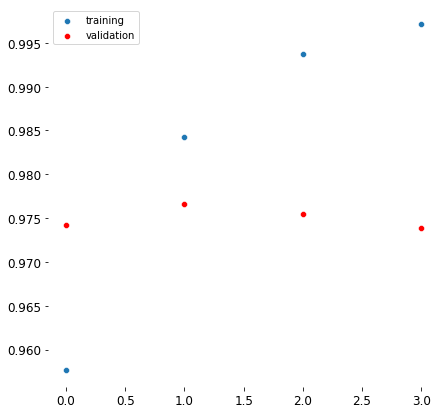

In [18]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize  = (7, 7))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
sns.scatterplot(x=history.epoch ,y=history.history['sparse_categorical_accuracy'], label='training')
sns.scatterplot(x=history.epoch ,y=history.history['val_sparse_categorical_accuracy'], color='red', label='validation')
ax.legend()
#plt.savefig("history.svg",bbox_inches='tight')

## Analisi prestazioni del modello di finale sui dati di test

- classification_report
- matrice di confusione

In [19]:
pred=final_model.predict(X_test)
y_pred=np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

451/451 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      7089
           1       0.97      0.98      0.97      7338

    accuracy                           0.97     14427
   macro avg       0.97      0.97      0.97     14427
weighted avg       0.97      0.97      0.97     14427



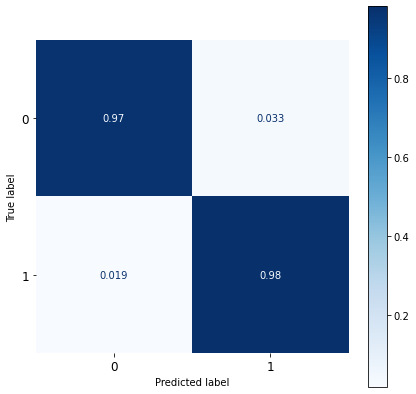

In [20]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize  = (7, 7))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Blues', ax=ax)
#plt.savefig("cf_matrix.svg",bbox_inches='tight')